# Data Storytelling

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import re
import gc # memory control
from textblob import TextBlob
from textblob import Word # for lemmatization
# from textblob.sentiments import NaiveBayesAnalyzer
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

## modules for generating the word cloud
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

sns.set(style="ticks")
plt.style.use('seaborn')

In [2]:
# read dataframe from wrangling procedure
df = pd.read_csv('df_clean_final.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)

In [3]:
df.head()

,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,helpfulness,review
0,A1I6CQYI2SZ4QY,000100039X,2.0,2011-11-06,Books,0.232667,0,0.0,Shame on me: I didn't read description. I revi...
1,A3KQL4H6XZN1FH,000100039X,2.0,2004-02-16,Books,0.232667,19,2.0,Fundamentally Flawed. Gibran reveals the funda...
2,A1TR1LU2JSZLUL,000100039X,5.0,2000-09-17,Books,0.232667,19,4.0,"Logical,rational thoughts on Love,Life,Death....."
3,ALD1CRUBY1365,000100039X,1.0,2002-05-22,Books,0.232667,53,2.0,Deceptively pseudo-scriptural. This book was a...
4,AACNFH28C1ZHB,000100039X,2.0,2005-04-01,Books,0.232667,10,2.0,A bit disappointed. I picked up this book afte...


# 1. Data preparation
I am using Amazone review dataset cleaned in previous wrangling stage which consists of 1,233,257 rows and 9 columns. In this step, I split the dataset into training and validation sets so that we can train and test classifier. Recall that our target is 'helpfulness'

In [4]:
## split the dataset into training and validation datasets 
## train:test = 4:1
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['helpfulness']), df['helpfulness'], 
                                                    test_size=0.2, random_state=77)

In [5]:
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1235906, 9), (988724, 8), (988724,), (247182, 8), (247182,))

In [6]:
X_train.head(3)

,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,review
230071,AWP6IU1LBWS6S,0615419178,4.0,2012-12-30,Books,0.495595,0,for a friend. She got very ill and died before...
199587,A269AK2RCT93YN,0470073942,5.0,2008-05-02,Books,0.353389,8,Rare insight into a frightening reality we all...
854224,A34CXLS24ETLMO,B000MG2LG8,5.0,2007-02-27,CDs & Vinyl,0.449565,16,The full-frontal-assault funk . . .. . . . pla...


In [7]:
y_train.head()

230071     0.0
199587     3.0
854224     4.0
539740     5.0
1056226    3.0
Name: helpfulness, dtype: float64

#  2. Feature Engineering for Text (Review) 
In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset. Also, I will try to summarize those features' characteristics with visualization.

> Following features will be added along the way:
    1. Sentiment Score as features
        * Polarity
        * Subjectivity
    2. Text / NLP based features
        * Word Count of the documents
        * Character Count of the documents
        * Average Word Density of the documnets
        * Punctuation Count in the Complete Review
        * Upper Case Count in the Complete Review
        * Title Word Count in the Complete Review
        * Frequency distribution of Part of Speech Tags:
            * Noun Count
            * Verb Count
            * Adjective Count
            * Adverb Count
            * Pronoun Count
    3. TF-IDF Vectors as features
        - Word level (O)
        - N-Gram level (X)
        - Character level (X)

## 2.1. Sentiment Analysis
Polarity is a float value within the range \[-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

Subjectivity is a float value within the range \[0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations where as Objective sentences are factual.

In [8]:
## train data
temp = X_train['review'].map(lambda x: TextBlob(x).sentiment).apply(pd.Series) 
## add sentiment polarity feature: [-1.0, 1.0]
X_train['polarity'] = temp[0]
## add sentiment subjectivity features: [0.0, 1.0]
X_train['subjectivity'] = temp[1]


## test data
temp = X_test['review'].map(lambda x: TextBlob(x).sentiment).apply(pd.Series) 
## add sentiment polarity feature: [-1.0, 1.0]
X_test['polarity'] = temp[0]
## add sentiment subjectivity features: [0.0, 1.0]
X_test['subjectivity'] = temp[1]


## delete temp dataframe and release RAM/memory
del [temp]
gc.collect();

In [9]:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)
# df_train.to_csv('df_train_v1.csv.gz', encoding='utf-8', index=False, compression='gzip')
# df_test.to_csv('df_test_v1.csv.gz', encoding='utf-8', index=False, compression='gzip')

### Visualize distibution of polarity and subjectivity

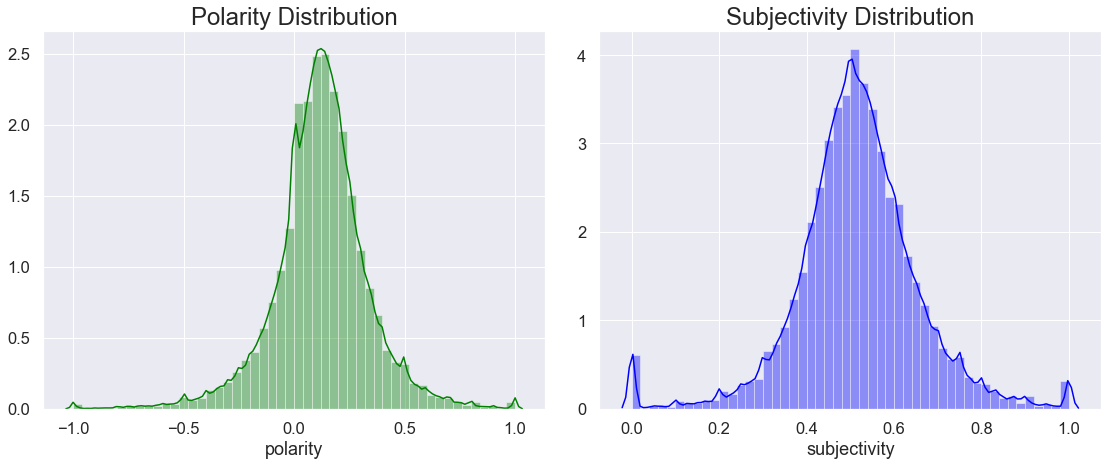

,polarity,subjectivity
count,988724.000000,988724.000000
mean,0.120556,0.515389
std,0.215015,0.141251
min,-1.000000,0.000000
25%,0.008333,0.442857
50%,0.123333,0.513571
75%,0.233745,0.590260
max,1.000000,1.000000


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.set(font_scale=2)

sns.distplot(X_train['polarity'], color='green', bins=50, hist_kws={'alpha': 0.4}, ax=ax1)
ax1.set_title('Polarity Distribution')

sns.distplot(X_train['subjectivity'], color='blue', bins=50, hist_kws={'alpha': 0.4}, ax=ax2)
ax2.set_title('Subjectivity Distribution')

plt.tight_layout()
plt.show()

X_train[['polarity', 'subjectivity']].describe()

We observe that both distribution seem symmetric from the mean. One peculiar thing is polarity is a little bit biased toward positive sentiment score (mean is 0.12, not 0.0) and subjectivity distribution shows there are some extremely subjective reviews (note 0.0 and 1.0 from the chart)

## 2.2 Visualize data based on helpfulness rating
First I will show worl cloud and then distribution of polarity and subjectivity

In [12]:
## For easiness of experiment, let's combine X_train, y_train together into a data frame
df = pd.concat([X_train, y_train], axis=1)

In [13]:
## divide dataframe based on helpfulness rating
df0 = df[df['helpfulness'] == 0.0]
df1 = df[df['helpfulness'] == 1.0]
df2 = df[df['helpfulness'] == 2.0]
df3 = df[df['helpfulness'] == 3.0]
df4 = df[df['helpfulness'] == 4.0]
df5 = df[df['helpfulness'] == 5.0]

## join all texts together
text0 = df0.review.str.cat(sep=" ")
text1 = df1.review.str.cat(sep=" ")
text2 = df2.review.str.cat(sep=" ")
text3 = df3.review.str.cat(sep=" ")
text4 = df4.review.str.cat(sep=" ")
text5 = df5.review.str.cat(sep=" ")

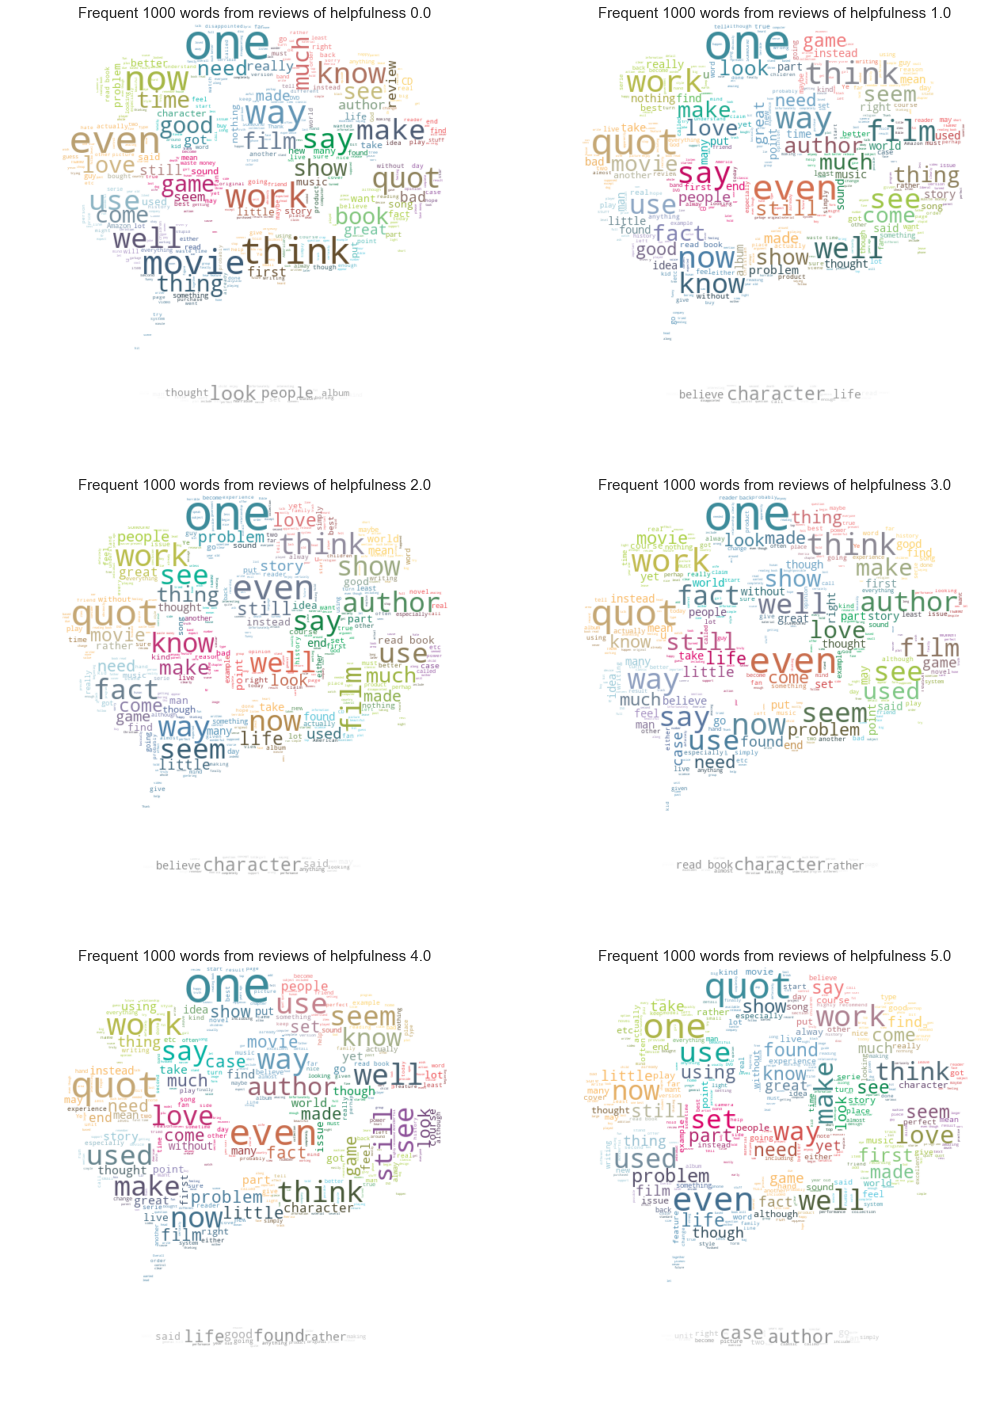

In [14]:
## get path of image
d = getcwd()
icon_path = path.join(d, "images/review_image.png")

## pre-set image
icon = Image.open(icon_path).convert("RGBA")
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon, icon)
mask = np.array(mask)

fig = plt.figure(figsize=(15, 20))

for i in range(6):
    ## Word Cloud with colored mask
    wc = WordCloud(background_color="white", max_words=1000, mask=mask,
                   max_font_size=90, random_state=42)
    wc.generate(globals()['text'+str(i)])

    ## create coloring from image
    coloring = np.array(Image.open(icon_path))
    image_colors = ImageColorGenerator(coloring)
    image_colors.default_color = [0.6, 0.6, 0.6]

    ## Generate word Cloud
#     plt.figure(figsize=(8,8))
    ax = fig.add_subplot(3, 2, i+1)
    ax.set_title('Frequent 1000 words from reviews of helpfulness {}'.format(float(i)), fontsize=15)
    ax.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    ax.axis("off")
    
plt.tight_layout()
plt.show();

At first glance, there are some words that are common in all word clouds

### Polarity and Subjectivity Distribution by helpfulness

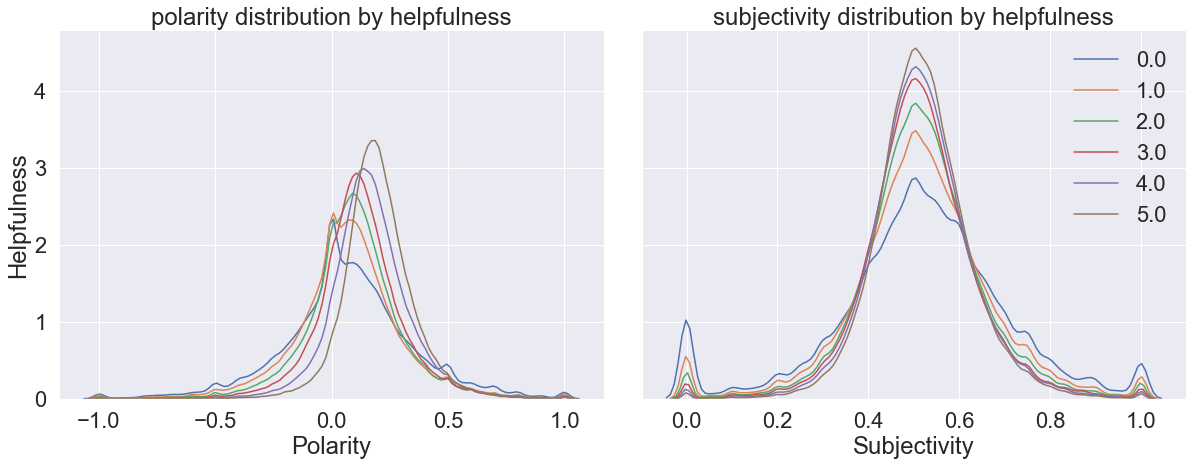

In [15]:
melted = df.melt(id_vars=['helpfulness'], value_vars=['polarity', 'subjectivity'])

g = sns.FacetGrid(melted, hue='helpfulness', col= 'variable', height=7, aspect=1.2, sharex=False)
g.map(sns.kdeplot, 'value')
g.set_titles('{col_name} distribution by helpfulness')
sns.despine(right = True, top = True)
g.axes[0,0].set_xlabel('Polarity')
g.axes[0,1].set_xlabel('Subjectivity')
g.axes[0,0].set_ylabel('Helpfulness')
plt.legend();

As we can see from polarity distribution, the higher helpfulness rating is the more polarity is biased toward the positive and its shape is pointed. On the other hand, subjectivity shows more centeralizing tendency as helpfulness increases

## 2.3 Text/NLP based features
A number of extra text based features can also be created which sometimes are helpful for improving text classification models.

1. Word Count of the documents – total number of words in the documents
2. Character Count of the documents – total number of characters in the documents
3. Average Word Density of the documnets – average length of the words used in the documents
4. Punctuation Count in the Complete Review – total number of punctuation marks in the documents
5. Upper Case Count in the Complete Review – total number of upper count words in the documents
6. Title Word Count in the Complete Review – total number of proper case (title) words in the documents
7. Frequency distribution of Part of Speech Tags:
    * Noun Count
    * Verb Count
    * Adjective Count
    * Adverb Count
    * Pronoun Count

In [16]:
X_train.head()

,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,review,polarity,subjectivity
230071,AWP6IU1LBWS6S,0615419178,4.0,2012-12-30,Books,0.495595,0,for a friend. She got very ill and died before...,-0.450000,0.944444
199587,A269AK2RCT93YN,0470073942,5.0,2008-05-02,Books,0.353389,8,Rare insight into a frightening reality we all...,-0.001389,0.504960
854224,A34CXLS24ETLMO,B000MG2LG8,5.0,2007-02-27,CDs & Vinyl,0.449565,16,The full-frontal-assault funk . . .. . . . pla...,0.301190,0.570833
539740,A152I1BISLYNP9,1884956580,5.0,2007-07-18,Books,0.428832,11,The American Directory of Writer's Guidelines....,0.223485,0.462879
1056226,APRGUNLAEPBBT,B004A2AN56,1.0,2010-12-22,Movies & TV,0.497003,25,I really wanted to like it. I like Michael Dou...,-0.113636,0.495455


In [17]:
## 1. Word count 
X_train['word_count'] = X_train['review'].apply(lambda x: len(x.split()))
X_test['word_count'] = X_test['review'].apply(lambda x: len(x.split()))

## 2. Character count 
X_train['char_count'] = X_train['review'].apply(len)
X_test['char_count'] = X_test['review'].apply(len)

## 3. Average word density
X_train['word_dencity'] = X_train['char_count'] / (X_train['word_count']+1)
X_test['word_dencity'] = X_test['char_count'] / (X_test['word_count']+1)

## 4. Pounctuation Count
X_train['punctuation_count'] = X_train['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
X_test['punctuation_count'] = X_test['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

## 5. Uppercase word count
X_train['uppercase_count'] = X_train['review'].apply(lambda x: len([word for word in x.split() if word.isupper()]))
X_test['uppercase_count'] = X_test['review'].apply(lambda x: len([word for word in x.split() if word.isupper()]))

## 6. Title word count
X_train['title_count'] = X_train['review'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
X_test['title_count'] = X_test['review'].apply(lambda x: len([word for word in x.split() if word.istitle()]))

In [18]:
## 7. Frequency distribution of POS

## group pos
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}


## function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x):
    noun = 0
    verb = 0
    adj = 0
    adv = 0
    pron = 0
    
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family['noun']:
                noun += 1
            elif ppo in pos_family['verb']:
                verb += 1
            elif ppo in pos_family['adj']:
                adj += 1
            elif ppo in pos_family['adv']:
                adv += 1
            elif ppo in pos_family['pron']:
                pron += 1
    except:
        pass
    return [noun, verb, adj, adv, pron]

##
def insert_pos(df, df_idx, indexes, start):
    count_holder = df.review.loc[df_idx[indexes[start]:indexes[start+1]]].map(check_pos_tag)
    
    df['noun_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[0])
    df['verb_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[1])
    df['adj_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[2])
    df['adv_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[3])
    df['pron_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[4])
    
    return df

In [19]:
X_train.shape, X_test.shape

((988724, 16), (247182, 16))

In [20]:
## define X_train indexes, helper array for chunk-ifying
df_idx = X_train.index.values
indexes = np.arange(0, 21)*50000

In [21]:
## initialize column
X_train['noun_count'] = 0
X_train['verb_count'] = 0
X_train['adj_count'] = 0
X_train['adv_count'] = 0
X_train['pron_count'] = 0

In [22]:
## split X_train data frame into 20 chunks and process. Each line takes on 50,000 rows except last one
X_train = insert_pos(X_train.copy(), df_idx, indexes, 0)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 1)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 2)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 3)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 4)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 5)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 6)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 7)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 8)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 9)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 10)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 11)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 12)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 13)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 14)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 15)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 16)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 17)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 18)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 19)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
# X_train.loc[df_idx[indexes[6]-10:indexes[6]+5]]

,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,review,polarity,subjectivity,...,char_count,word_dencity,punctuation_count,uppercase_count,title_count,noun_count,verb_count,adj_count,adv_count,pron_count
1177710,A7BQ889N1FWOC,B00A2XTHYU,5.0,2012-11-12,Movies & TV,0.440539,5,The Men Who Built America [Blu-ray]. My The Me...,0.242857,0.417857,...,137,5.074074,7,0,11,16,4,1,3,2
1205662,A2B0CBK6W8Q59K,B00CX8VYM0,1.0,2013-12-21,Video Games,0.471535,7,Save game Glitches and terrible support from U...,-0.183910,0.480171,...,1664,5.621622,32,9,34,72,52,25,21,31
877168,A19GEE9O8TQW4E,B000TGJ8B2,5.0,2007-12-25,Movies & TV,0.791457,22,"Classic Series, Outstanding Set. It goes witho...",0.244369,0.530257,...,3460,5.607780,75,11,45,154,100,55,52,36
846012,A2E0EZ8DO5YSU3,B000JMK6LW,1.0,2007-01-08,Movies & TV,0.324175,2,Warning - this is a cartoon - and it's awful!....,-1.000000,1.000000,...,236,5.363636,14,2,5,8,12,3,2,7
1104397,A103LEFS18A9JD,B005H0OEJ6,3.0,2011-09-26,Movies & TV,0.440539,0,It would have been more.. It would have been a...,0.500000,0.437500,...,135,5.000000,5,0,3,3,8,3,1,3
954864,AQTK27CWIP015,B001QA4RZ2,1.0,2011-09-06,Books,0.259105,0,bought by accident. i had read one book by thi...,0.031250,0.333333,...,233,5.418605,5,0,0,10,7,4,2,2
908896,A2IXSFUJ5YN706,B0015AUOSC,1.0,2009-05-05,"Patio, Lawn & Garden",0.418284,13,Fireman's Nozzle. Looks great but the pressure...,-0.112857,0.609286,...,343,5.622951,10,3,14,20,9,5,5,5
1112263,A225RU0HGCK9L5,B005O0X4DQ,1.0,2013-09-15,Health & Personal Care,0.510377,8,Such a waste of money. I have used other wrap ...,-0.152500,0.325000,...,149,4.806452,3,2,4,7,5,6,0,2
901236,ASRA2UZ3JV87B,B0012K3EWS,3.0,2006-07-06,Beauty,0.371261,11,Use sparingly... and outdoors!. I was planning...,-0.006250,0.322917,...,760,5.588235,31,7,13,27,30,15,12,15
889316,A83G9PHBMOB6P,B000WOV83M,1.0,2012-06-15,"Arts, Crafts & Sewing",0.816093,6,DON'T BUY PROVO CRAFT. Go with the silhouette....,0.014286,0.419286,...,406,5.970588,18,9,7,17,19,7,3,9


In [45]:
## define X_test indexes, helper array for chunk-ifying
df_idx = X_test.index.values
indexes = np.arange(0, 6)*50000

In [46]:
## initialize column
X_test['noun_count'] = 0
X_test['verb_count'] = 0
X_test['adj_count'] = 0
X_test['adv_count'] = 0
X_test['pron_count'] = 0

In [47]:
# ## split X_train data frame into 5 chunks and process. Each line takes on 50,000 rows except last one
X_test = insert_pos(X_test.copy(), df_idx, indexes, 0)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 1)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 2)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 3)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 4)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
X_train.head(3)

,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,review,polarity,subjectivity,...,char_count,word_dencity,punctuation_count,uppercase_count,title_count,noun_count,verb_count,adj_count,adv_count,pron_count
230071,AWP6IU1LBWS6S,0615419178,4.0,2012-12-30,Books,0.495595,0,for a friend. She got very ill and died before...,-0.450000,0.944444,...,108,4.320000,2,1,2,1,5,3,2,6
199587,A269AK2RCT93YN,0470073942,5.0,2008-05-02,Books,0.353389,8,Rare insight into a frightening reality we all...,-0.001389,0.504960,...,725,6.651376,16,2,4,32,17,14,6,10
854224,A34CXLS24ETLMO,B000MG2LG8,5.0,2007-02-27,CDs & Vinyl,0.449565,16,The full-frontal-assault funk . . .. . . . pla...,0.301190,0.570833,...,1097,5.866310,67,4,26,54,37,15,16,14


In [53]:
X_test.head(3)

,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,review,polarity,subjectivity,...,char_count,word_dencity,punctuation_count,uppercase_count,title_count,noun_count,verb_count,adj_count,adv_count,pron_count
33967,A3OL1AX1IODBYL,0062206451,5.0,2013-10-13,Books,0.344157,9,LIVES DERAILED BY SHOCKING SCANDAL. In the ope...,0.198377,0.456285,...,2176,5.681462,56,8,19,100,51,25,27,37
534050,A195GMC8TGVQWL,1847190901,1.0,2008-06-30,Books,0.497003,7,Both generally useless and annoying. UPDATE: D...,-0.047731,0.519237,...,2842,6.021186,64,4,23,107,90,43,42,30
595077,AT576Z9DC6HJ0,B000002503,2.0,2002-09-04,CDs & Vinyl,0.251413,5,Sorry I asked.... Blue Oyster Cult has always ...,-0.019611,0.405797,...,923,5.429412,54,13,35,49,33,9,13,17


In [54]:
X_train.shape, X_test.shape

((988724, 21), (247182, 21))

In [55]:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)
# df_train.to_csv('df_train_v2.csv.gz', encoding='utf-8', index=False, compression='gzip')
# df_test.to_csv('df_test_v2.csv.gz', encoding='utf-8', index=False, compression='gzip')

## 2.3. TF-IDF Vectors as features (TBD)

__I have not decided what to do with TF-IDF specifically. As of now, I think I cause use this feature as base model for naive bayes. However since this feature has such a large volumn, I need consultation with my mentor__ 

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

>TF(t) = (Number of times term t appears in a document) / (Total number of terms in the  document) <br>
 IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

1. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
2. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
3. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

Given the size of data is large, we achieve 1.unigram setting ngram_range(1,1) 

In [169]:
# STEMMER = SnowballStemmer("english")
PUNCTUATION = str.maketrans('', '', string.punctuation)
DIGITS = str.maketrans('', '', string.digits)

def preprocess_text(text):    
    ## convert to lowercase, remove punctuation & remove numbers
    text = text.lower().translate(PUNCTUATION).translate(DIGITS)
    ## lemmatize words & remove extra spaces
    text = " ".join([Word(word).lemmatize("v") for word in TextBlob(text).words])
    
    return text

In [172]:
X_train_review = X_train.review.copy()
X_test_review = X_test.review.copy()

In [176]:
# takes 40 minutes
X_train_review_clean = X_train_review.map(preprocess_text)

In [178]:
X_test_review_clean = X_test_review.map(preprocess_text)

In [179]:
X_test_review_clean.tail()

236531    down to earth beyond this short book be write ...
726711    cheap trick we all know the drill release the ...
150950    catholics need to buy this as someone who have...
538178    great content but useless to the japanese i re...
296338    dun be historically accurate not racist i have...
Name: review, dtype: object

In [181]:
X_test_review_clean.shape

(246652,)

In [182]:
# X_train_review_clean.to_csv('X_train_review_clean.csv.gz', encoding='utf-8', index=False, compression='gzip')
# X_test_review_clean.to_csv('X_test_review_clean.csv.gz', encoding='utf-8', index=False, compression='gzip')

In [347]:
## filter out stop words of English, and too frequently used words are out, less than 10 times (< 0.00081%) used words are out
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), 
                             min_df=10, max_df=0.70, stop_words='english')
V_train = vectorizer.fit_transform(X_train_review_clean)

In [ ]:
V_test = vectorizer.transform(X_test_review_clean)

Looking at "vectorizer.stop_words_", we can tell there are many words that look typos or was not splitted as it is supposed to be.

In [349]:
len(vectorizer.vocabulary_), len(vectorizer.stop_words_)

(131681, 2125526)

In [350]:
vectorizer.stop_words_

{'boytraci',
 'quotmutantsquot',
 'myselfchris',
 'heartwise',
 'everytimedreaming',
 'findg',
 'malisimo',
 'hartwvud',
 'holdwhat',
 'richeswas',
 'thosetaking',
 'lazyplease',
 'vocabuary',
 'youtubenetflixpandora',
 'eastthroughout',
 'jointback',
 'titimovie',
 'clickyou',
 'satanicpanic',
 'tropestheres',
 'episodesmpi',
 'syestem',
 'cherrypcked',
 'projectcasual',
 'megamartstrongly',
 'lawseven',
 'naiveedit',
 'tixeront',
 'highlighteryellow',
 'mandalafrom',
 'everok',
 'combatively',
 'fanthough',
 'detemine',
 'gilgameshhe',
 'fakesa',
 'englishalong',
 'flameswhen',
 'pointsgive',
 'childrenpeople',
 'heracleshercules',
 'groupcould',
 'changerbuy',
 'symptomaticagainst',
 'constitutiondont',
 'detectiverobert',
 'disappint',
 'chinasometimes',
 'impes',
 'okbutnotgreat',
 'dudemaybe',
 'practicetests',
 'pilsners',
 'exbodyguard',
 'zhuangjanjoongsince',
 'decepicionado',
 'beveragei',
 'performanceunlike',
 'woyld',
 'generationes',
 'cpuheavy',
 'olderdifferent',
 'mei

In [343]:
len(vectorizer.stop_words_)

2026209

In [ ]:
V_train.shape, X_train.shape

In [ ]:
V_test.shape, X_test.shape

In [ ]:
train_tfidf = pd.DataFrame(V_train, columns=vectorizer.get_feqture_names(), index=X_train.index)

In [ ]:
test_tfidf = pd.DataFrame(V_test, columns=vectorizer.get_feqture_names(), index=X_test.index)

In [44]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

# 3. Data Exploration
I will do some experiment with data so I can get inspiration and may find patterns

In [58]:
# information of X_train + y_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988724 entries, 230071 to 703191
Data columns (total 22 columns):
reviewerID           988724 non-null object
asin                 988724 non-null object
overall              988724 non-null float64
reviewTime           988724 non-null datetime64[ns]
categories           988724 non-null object
price                988724 non-null float64
helpful_num          988724 non-null int64
review               988724 non-null object
polarity             988724 non-null float64
subjectivity         988724 non-null float64
word_count           988724 non-null int64
char_count           988724 non-null int64
word_dencity         988724 non-null float64
punctuation_count    988724 non-null int64
uppercase_count      988724 non-null int64
title_count          988724 non-null int64
noun_count           988724 non-null int64
verb_count           988724 non-null int64
adj_count            988724 non-null int64
adv_count            988724 non-null int64
p

## 3.1 Numerical Features
Let us first study collinearity among features and correlation between numerical features and our target - helpfulness
### 3.1.1 collinearity

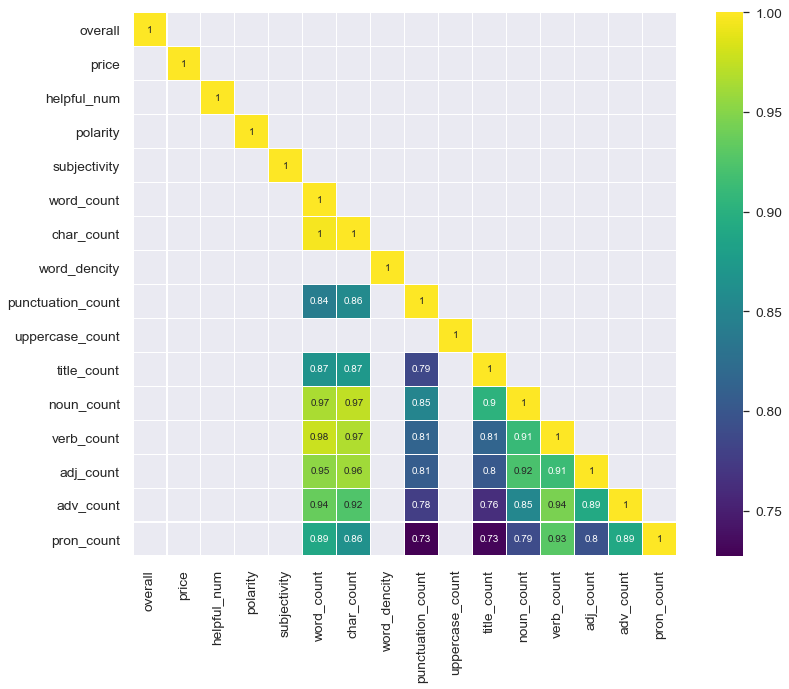

In [69]:
sns.set(font_scale=1.25)
corr = df_train.select_dtypes([int, float]).drop(columns=['helpfulness']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
plt.figure(figsize=(14,10))
with sns.axes_style("darkgrid"):
    sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], cmap='viridis', mask=mask,
                annot=True, annot_kws={'size':10}, square=True, linewidths=0.2);

We can see that noun_count, verb_count, adj_count, adv_count pron_count, word_count, char_count, punctuation count, and title_count are stronly correlated to each other. Basically, almost all count features except uppercase_count are strongly correlated and it seems somewhat natural because the longer review is, the more likely any count would increase due to English structure. For this reason, __we'll remove those highly correlated features regarding them as duplicated features; and will keep 'word_count' as a representative feature because it shows strongest collinearity with other features and has strong correlation with the target (reference 3.1.2)__

### 3.1.2 Correlation with Helpfulness

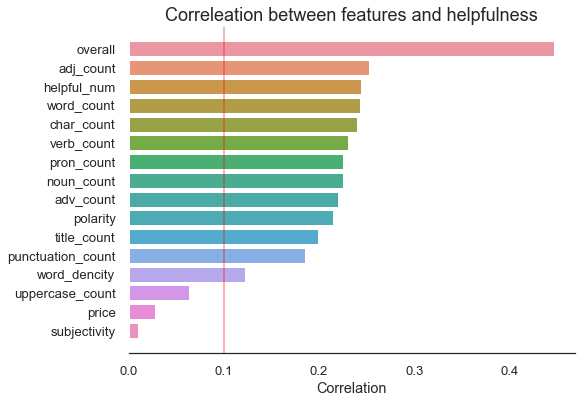

In [70]:
corr_with_target = df_train.select_dtypes([int, float]).corr()['helpfulness'].drop(['helpfulness']).sort_values(ascending=False)
sns.set(font_scale=1.2)

with sns.axes_style('white'):
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x=corr_with_target, y=corr_with_target.index)
    sns.despine(top=True, right=True, left=True)
    ax.set_title('Correleation between features and helpfulness', fontsize=18)
    # By using ``transform=ax.get_xaxis_transform()`` the y coordinates are scaled
    # such that 0 maps to the bottom of the axes and 1 to the top.
    ax.vlines(0.1, 0,1, transform=ax.get_xaxis_transform(), colors='red', alpha=0.4)
    ax.set_xlabel('Correlation')

Vertical line in red is on 0.1 which will be a criteron on determining if a feature has a strong correlation with helpfulness rating. Subjectivity shows least correlation which might denote either TextBlob does not catch subjectivity or people do not vote subjective reviews as helpful. helpful_num has high correlation as expected. Overall rating shows strongest correlation with helpfulness. Surprisingly, price has little correlation opposed to what I expected. __This results implies that 'uppercase_count', 'price' and 'subjectivity' will not be of helpful for prediction; therefore, I will drop them.__

In [81]:
drop_col = ['uppercase_count', 'price', 'subjectivity', 'char_count', 'punctuation_count', 'title_count', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']

X_train = X_train.drop(columns=drop_col)
X_test = X_test.drop(columns=drop_col)

In [84]:
X_train.head(3)

,reviewerID,asin,overall,reviewTime,categories,helpful_num,review,polarity,word_count,word_dencity
230071,AWP6IU1LBWS6S,0615419178,4.0,2012-12-30,Books,0,for a friend. She got very ill and died before...,-0.450000,24,4.320000
199587,A269AK2RCT93YN,0470073942,5.0,2008-05-02,Books,8,Rare insight into a frightening reality we all...,-0.001389,108,6.651376
854224,A34CXLS24ETLMO,B000MG2LG8,5.0,2007-02-27,CDs & Vinyl,16,The full-frontal-assault funk . . .. . . . pla...,0.301190,186,5.866310


In [85]:
X_test.head(3)

,reviewerID,asin,overall,reviewTime,categories,helpful_num,review,polarity,word_count,word_dencity
33967,A3OL1AX1IODBYL,0062206451,5.0,2013-10-13,Books,9,LIVES DERAILED BY SHOCKING SCANDAL. In the ope...,0.198377,382,5.681462
534050,A195GMC8TGVQWL,1847190901,1.0,2008-06-30,Books,7,Both generally useless and annoying. UPDATE: D...,-0.047731,471,6.021186
595077,AT576Z9DC6HJ0,B000002503,2.0,2002-09-04,CDs & Vinyl,5,Sorry I asked.... Blue Oyster Cult has always ...,-0.019611,169,5.429412


In [86]:
df_train = pd.concat([X_train, y_train], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)
# df_train.to_csv('df_train_v3.csv.gz', encoding='utf-8', index=False, compression='gzip')
# df_test.to_csv('df_test_v3.csv.gz', encoding='utf-8', index=False, compression='gzip')

### 3.1.3 Other Numerical Features
Let us explore numerical features with pair plot.

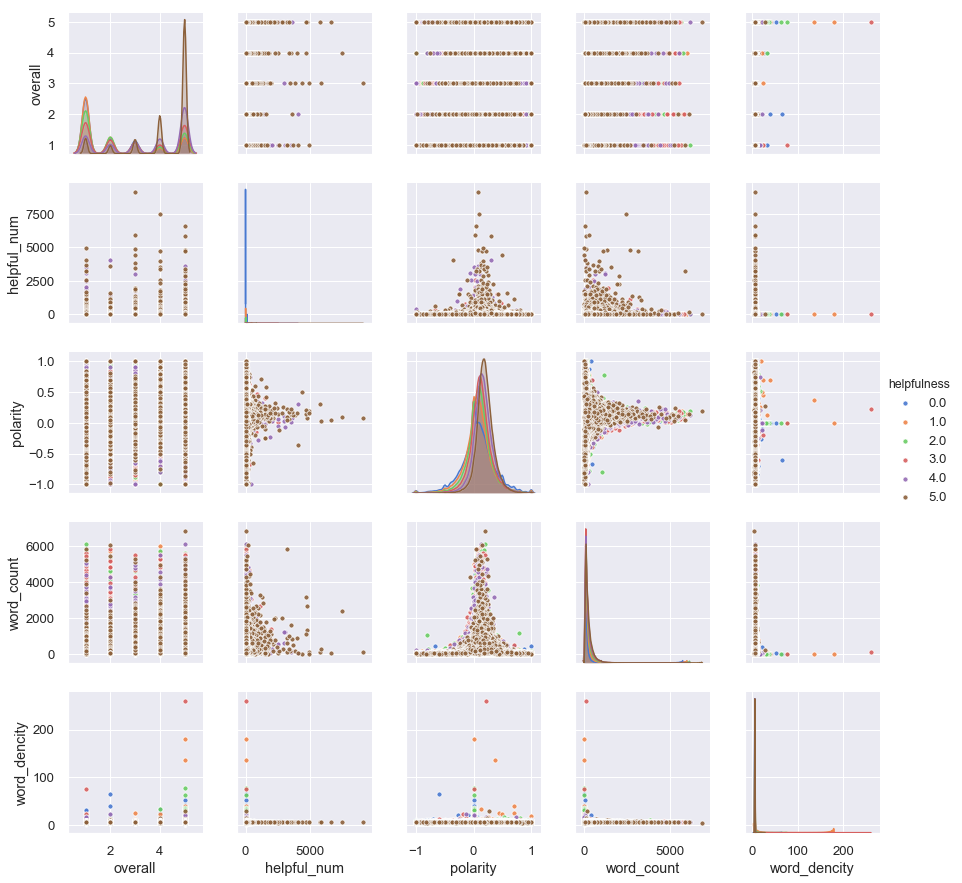

In [117]:
numericals = df_train.select_dtypes([int, float]).copy()

sns.pairplot(df_train.select_dtypes([int, float]), hue='helpfulness', palette='muted',
             vars=numericals.columns.drop(['helpfulness']).vmalues, plot_kws={'alpha': 0.9, 's':25});

There are some points worth dicsussing:
1. From polarity-helpful_num scatter plot, users tend not to vote for polar reviews; they want neutral reviews.
2. helpful_num and word_count are seemingly in inverse proportion to each other, that shows people do not usually favors very length reivew. 
3. Given word_dencity related plots, people do not like "big" words. Because, by definition, word dencity is average length of the words used. 
4. From overall distribution, we can see it is biased toward rating 1 or 5 which shows people rate the product rather in extreme fashion
5. helpful number is highly right-skewed 

## 3.2 Categorical Features

In [122]:
categoricals = df_train.select_dtypes([object])
categoricals = pd.concat([categoricals, df_train.helpfulness], axis=1)
categoricals.head()

,reviewerID,asin,categories,review,helpfulness
230071,AWP6IU1LBWS6S,0615419178,Books,for a friend. She got very ill and died before...,0.0
199587,A269AK2RCT93YN,0470073942,Books,Rare insight into a frightening reality we all...,3.0
854224,A34CXLS24ETLMO,B000MG2LG8,CDs & Vinyl,The full-frontal-assault funk . . .. . . . pla...,4.0
539740,A152I1BISLYNP9,1884956580,Books,The American Directory of Writer's Guidelines....,5.0
1056226,APRGUNLAEPBBT,B004A2AN56,Movies & TV,I really wanted to like it. I like Michael Dou...,3.0


* Dist. of number of reviews per user
* number of reviews per categories
* Average helpfulness by categories


later, 
* helpfulness over time

### 3.2.1 Distribution of number of reviews per user 

In [130]:
print("User number is: {}".format(categoricals.reviewerID.unique().shape[0]))
print("Review ratio to user number is: {}".format(categoricals.shape[0]/categoricals.reviewerID.unique().shape[0]))

User number is: 728666
Review ratio to user number is: 1.3568960264373526


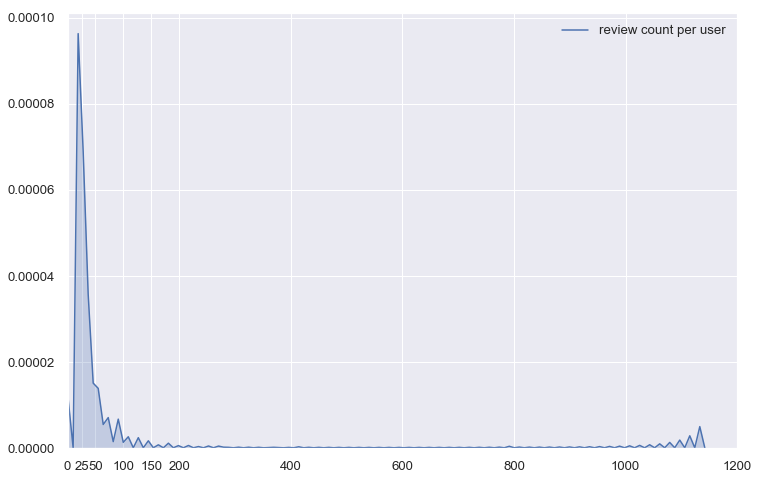

In [154]:
cat_df = categoricals.groupby(['reviewerID'])['helpfulness'].count().rename("review count per user")
plt.figure(figsize=(12,8))
ax = sns.kdeplot(cat_df, shade=True);
ax.set_xlim((0, 1200))
ax.set_xticks([0, 25, 50, 100, 150, 200, 400, 600, 800, 1000, 1200]);

It seems not many people write more than 1 review from mean review number per user. However, we can see that review number is highly right skewed and after 20 review count, graph plummets. Also we can observe that there are some "super" users who writes reviews more than 1000 times. 

### 3.2.2 Helpfulness distribution by categories & Number of reviews per categories

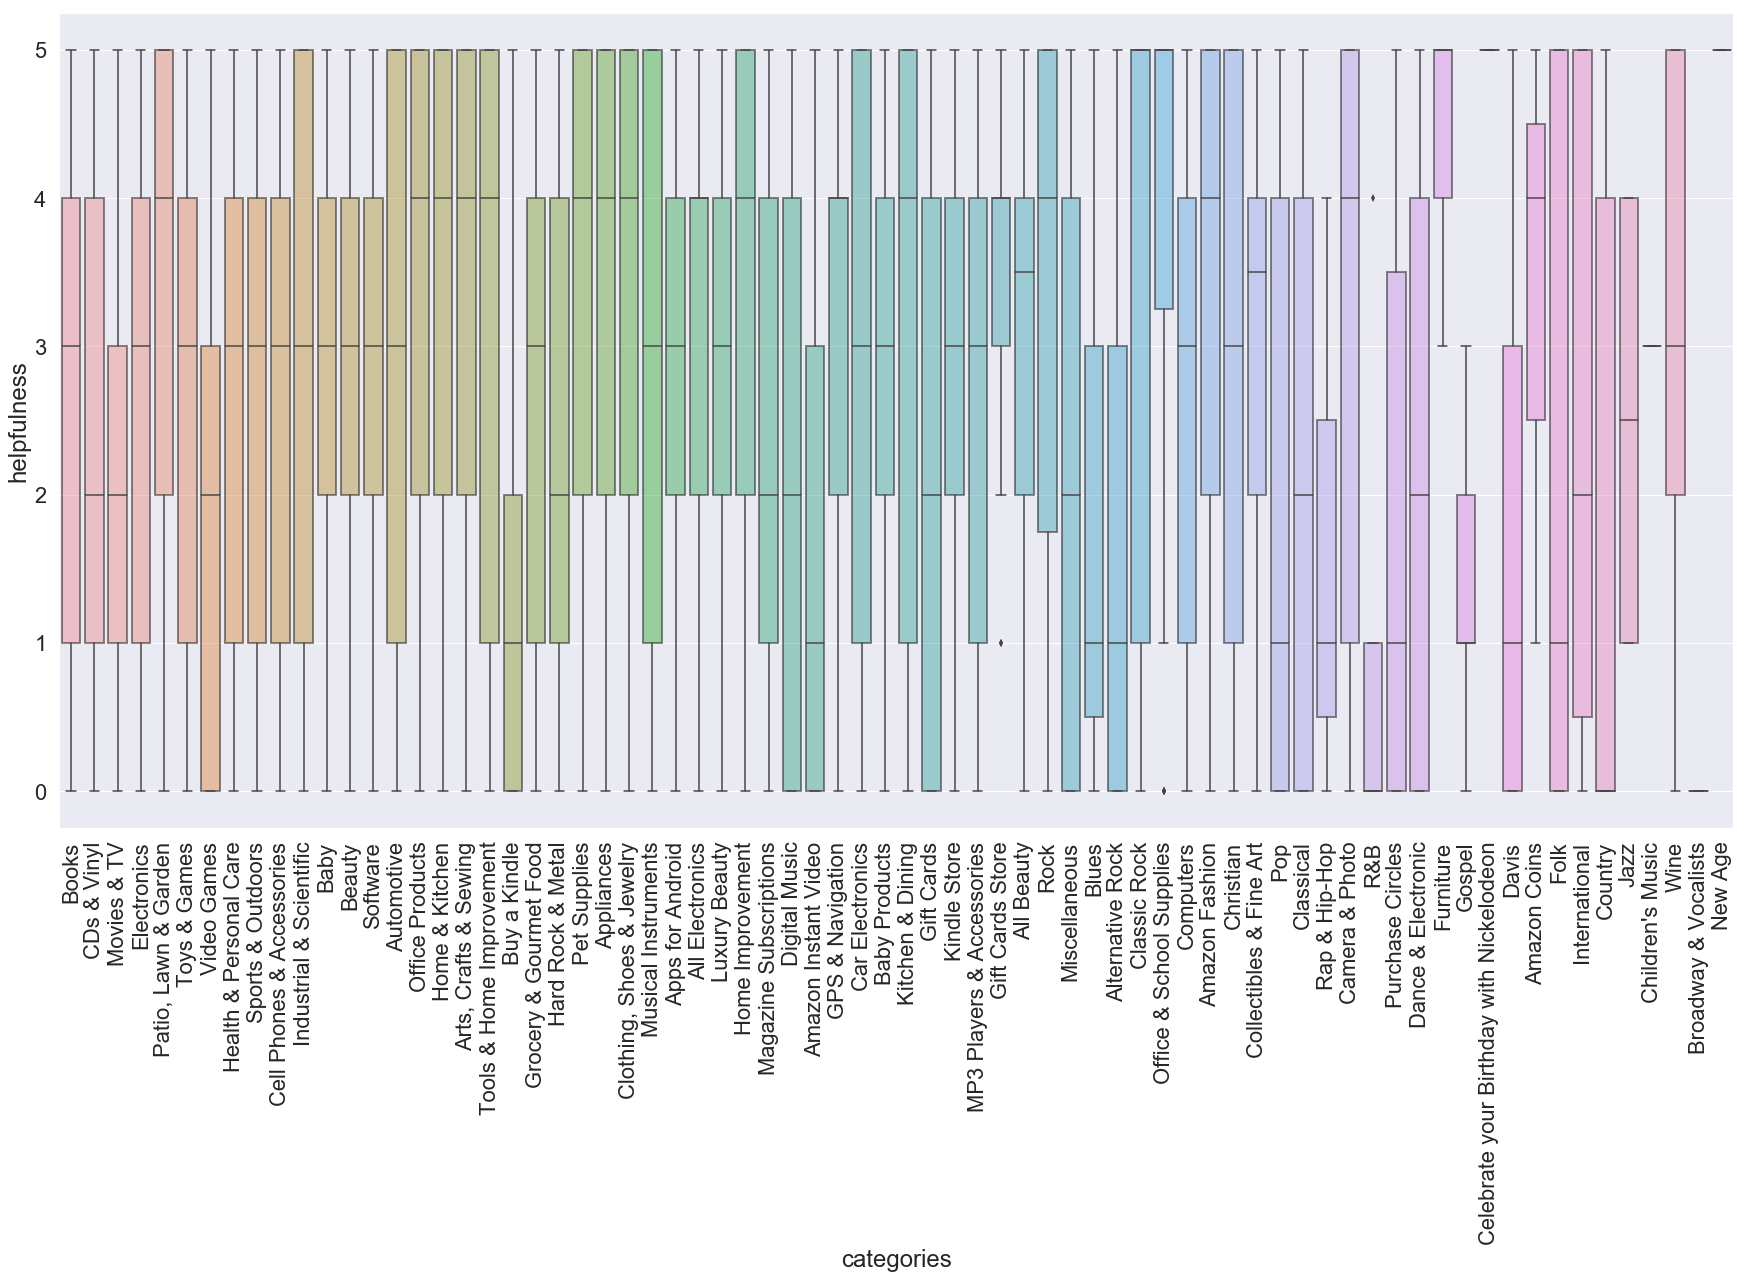

In [162]:
plt.figure(figsize=(30, 15))
sns.set(font_scale=2)
ax = sns.boxplot(x='categories', y='helpfulness', data=categoricals)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=90);

In [ ]:
categoricals.groupby(['categories'])['helpfulness'].count().rename("count per categories")